# Gene sorting by KEGG functional annotations (TreeMap)
This notebook is based on the paper *OmicsMapNet: Transforming omics data to take advantage of Deep Convolutional Neural Network for discovery*, whose authors are *Shiyong Ma, Zhen Zhang* (https://arxiv.org/ftp/arxiv/papers/1804/1804.05283.pdf)
- Paper summary: 
Their aim was to rearrange high-dimensional omics data as 2-dimensional images, and train a Keras-CNN with them. For that, they used KEGG database which provides functional anotation of genes. Specifically, KEGG BRITE captures 'the functional hierarchies of biological objects'. And based on this hierarchy, each omic vector was shaped as an image using a treemap.

In [1]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import squarify 

###  KEGG and TCGA data loading

- Data coming from KEGG database is fetched on 'KEGG_Data_obtaining.ipynb' notebook
- Data coming from TCGA database is fetched on 'TCGA_Data_obtaining.ipynb' notebook

In [3]:
# KEGG
hsa = pd.read_csv('data/KEGG/KEGG_gene_hsa.csv', sep='\t'  , engine='python', header=None, index_col=0)
hsa_brite = pd.read_csv('data/KEGG/KEGG_hsa_brite.csv', sep='\t'  , engine='python', header=None)
hsa_brite.columns = ['keggBriteId', 'keggId']
brite = pd.read_csv('data/KEGG/KEGG_brite.csv', engine='python', header=0, index_col=0)

# TCGA

# pp_df_gene_exp = pd.read_hdf("data/preprocessed1_expr.h5", key='expression') # only selected features
# df_gene_exp = pd.read_hdf("data/TCGA_data.h5", key='both_gene_expression') # all

brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "brca")
non_brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "non_brca")

In [4]:
hsa_brite['keggBriteId'] = [br_id[7:] for br_id in hsa_brite['keggBriteId']]

In [5]:
brite_homosap_index = list(set(brite['keggBriteId']).intersection(set(hsa_brite['keggBriteId'])))

In [6]:
brite = brite.loc[brite['keggBriteId'].isin(brite_homosap_index)]

In [7]:
ens_genes = brca_ex.columns

In [8]:
len(ens_genes)

20000

## MAPPING: From Ensembl Gene ID to KEGG BRITE functional annotation
KEGG relates Hugo-gene-names to an internal id (KEGG id) that is useful to find out the corresponding KEGG BRITE value/s (hierarchical functional annotations) of each gene.
Due to genes in TCGA are indexed by Ensembl-ids, it is needed mapping Ensembl-id to Hugo-gene-name

All the code below (mappings) can be ignored until next section just loading 'gene_mapping' DataFrame, which contains mapping from Ensembl id to KEGG Brite

In [10]:
# Loading 'gene_mapping' DataFrame
gene_mapping = pd.read_hdf('data/KEGG/map_ens_kegg_brite.h5', key='map')

### Mapping: Ensembl Gene ID to  Hugo Gene Name
Down below, it is downloaded a table relating ensembl-ids and hugo-gene-names from this URL: https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv

In [11]:
%%time

url = 'https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv'
hugo_request = requests.get(url, allow_redirects=True)
open('data/hugo_ensembl.tsv', 'wb').write(hugo_request.content)
del hugo_request

CPU times: user 300 ms, sys: 178 ms, total: 479 ms
Wall time: 4.86 s


In [12]:
hugo_ens = pd.read_csv('data/hugo_ensembl.tsv', sep='\t', engine='python', index_col=0)

In [13]:
hugo_ens = hugo_ens[~hugo_ens.index.duplicated()]

common_genes = hugo_ens.index.intersection(ens_genes)
hugo_ens = hugo_ens.loc[common_genes, :]

len(common_genes)

20000

In [14]:
hugo_ens

,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
ENSG00000227232.5,WASH7P,unprocessed_pseudogene,KNOWN,ENST00000488147.1,WASH7P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000000958.1,OTTHUMT00000002839.1,NaN,2,pseudo
ENSG00000238009.6,RP11-34P13.7,lincRNA,KNOWN,ENST00000466430.5,RP11-34P13.7-001,lincRNA,KNOWN,OTTHUMG00000001096.2,OTTHUMT00000003225.1,NaN,2,nonCoding
ENSG00000239945.1,RP11-34P13.8,lincRNA,KNOWN,ENST00000495576.1,RP11-34P13.8-001,lincRNA,KNOWN,OTTHUMG00000001097.2,OTTHUMT00000003226.2,NaN,2,nonCoding
ENSG00000233750.3,CICP27,processed_pseudogene,KNOWN,ENST00000442987.3,CICP27-001,processed_pseudogene,KNOWN,OTTHUMG00000001257.3,OTTHUMT00000003691.3,NaN,1,pseudo
ENSG00000268903.1,RP11-34P13.15,processed_pseudogene,KNOWN,ENST00000494149.2,RP11-34P13.15-001,processed_pseudogene,KNOWN,OTTHUMG00000182518.2,OTTHUMT00000461982.2,NaN,1,pseudo
ENSG00000269981.1,RP11-34P13.16,processed_pseudogene,KNOWN,ENST00000595919.1,RP11-34P13.16-001,processed_pseudogene,KNOWN,OTTHUMG00000182738.2,OTTHUMT00000463398.2,NaN,2,pseudo
ENSG00000241860.6,RP11-34P13.13,processed_transcript,KNOWN,ENST00000484859.1,RP11-34P13.13-004,antisense,KNOWN,OTTHUMG00000002480.3,OTTHUMT00000007035.1,NaN,2,nonCoding
ENSG00000228463.8,AP006222.2,lincRNA,KNOWN,ENST00000442116.1,AP006222.2-003,lincRNA,KNOWN,OTTHUMG00000002553.2,OTTHUMT00000007244.1,NaN,2,nonCoding
ENSG00000241670.3,RPL23AP21,processed_pseudogene,KNOWN,ENST00000450734.1,RPL23AP21-001,processed_pseudogene,KNOWN,OTTHUMG00000002552.1,OTTHUMT00000007241.1,NaN,1,pseudo
ENSG00000236679.2,RPL23AP24,processed_pseudogene,KNOWN,ENST00000458203.2,RPL23AP24-004,processed_pseudogene,KNOWN,OTTHUMG00000002854.4,OTTHUMT00000346877.2,NaN,1,pseudo


In [15]:
gene_mapping = pd.DataFrame(hugo_ens.loc[:,'geneName'])

In [16]:
gene_mapping['ensId'] = gene_mapping.index

In [17]:
gene_mapping['geneName']

ENSG00000227232.5            WASH7P
ENSG00000238009.6      RP11-34P13.7
ENSG00000239945.1      RP11-34P13.8
ENSG00000233750.3            CICP27
ENSG00000268903.1     RP11-34P13.15
ENSG00000269981.1     RP11-34P13.16
ENSG00000241860.6     RP11-34P13.13
ENSG00000228463.8        AP006222.2
ENSG00000241670.3         RPL23AP21
ENSG00000236679.2         RPL23AP24
ENSG00000237094.11    RP4-669L17.10
ENSG00000250575.1      RP4-669L17.8
ENSG00000231709.1      RP5-857K21.1
ENSG00000230021.7      RP5-857K21.4
ENSG00000225972.1          MTND1P23
ENSG00000225630.1          MTND2P28
ENSG00000237973.1      RP5-857K21.6
ENSG00000229344.1      RP5-857K21.7
ENSG00000240409.1          MTATP8P1
ENSG00000248527.1          MTATP6P1
ENSG00000198744.5     RP5-857K21.11
ENSG00000229376.3             CICP3
ENSG00000224956.5     RP11-206L10.1
ENSG00000235373.1     RP11-206L10.3
ENSG00000240618.1     RP11-206L10.5
ENSG00000228327.2     RP11-206L10.2
ENSG00000237491.8     RP11-206L10.9
ENSG00000230092.7     RP11-2

### Mapping: Hugo Gene Name to KEGG gene id

In [18]:
hsa_hugo_dict = dict()
for i in range(0, len(hsa)):
    value = hsa.loc[hsa.index[i],1].split(";")[0].split(',')
    if 'uncharacterized' not in value[0] and len(value[0])<20:
        hsa_hugo_dict[hsa.index[i]] = value

In [19]:
len(hsa_hugo_dict)

26988

In [20]:
%%time
hsa_hugo = pd.DataFrame(columns=['keggId','geneName'])
i = 0
for key, values in hsa_hugo_dict.items():
    for ens in values:
        hsa_hugo.loc[i] = [key, ens]
        i+=1

CPU times: user 3min 3s, sys: 151 ms, total: 3min 3s
Wall time: 3min 3s


In [21]:
hsa_hugo.shape

(86160, 2)

In [22]:
gene_mapping = pd.merge(gene_mapping, hsa_hugo, on='geneName')

### Mapping: KEGG gene id to KEGG BRITE id

In [23]:
gene_mapping

,geneName,ensId,keggId
0,WASH7P,ENSG00000227232.5,hsa:653635
1,WASH7P,ENSG00000226210.3,hsa:653635
2,FAM87B,ENSG00000177757.2,hsa:400728
3,LINC00115,ENSG00000225880.5,hsa:79854
4,FAM41C,ENSG00000230368.2,hsa:284593
5,SAMD11,ENSG00000187634.10,hsa:148398
6,KLHL17,ENSG00000187961.13,hsa:339451
7,PLEKHN1,ENSG00000187583.10,hsa:84069
8,PERM1,ENSG00000187642.9,hsa:84808
9,HES4,ENSG00000188290.10,hsa:57801


In [24]:
len(set(hsa_brite['keggId'].value_counts().index).intersection(gene_mapping['keggId']))

7287

In [25]:
gene_mapping = pd.merge(gene_mapping, hsa_brite, on='keggId')

In [26]:
gene_mapping

,geneName,ensId,keggId,keggBriteId
0,KLHL17,ENSG00000187961.13,hsa:339451,0001
1,KLHL17,ENSG00000187961.13,hsa:339451,4121
2,HES4,ENSG00000188290.10,hsa:57801,0001
3,HES4,ENSG00000188290.10,hsa:57801,3000
4,ISG15,ENSG00000187608.8,hsa:9636,0001
5,ISG15,ENSG00000187608.8,hsa:9636,4121
6,AGRN,ENSG00000188157.13,hsa:375790,0001
7,AGRN,ENSG00000188157.13,hsa:375790,0535
8,TNFRSF18,ENSG00000186891.13,hsa:8784,0001
9,TNFRSF18,ENSG00000186891.13,hsa:8784,4090


### Mapping: KEGG BRITE id to KEGG BRITE functional annotation

In [27]:
gene_mapping = pd.merge(gene_mapping, brite, on='keggBriteId')

In [28]:
brite

,Functional Annotation Group,Functional Annotation Subgroup,keggBriteId,Functional Annotation
4,Genes and Proteins,Orthologs and modules,0001,KEGG Orthology (KO)
7,Genes and Proteins,Protein families: metabolism,1000,Enzymes
8,Genes and Proteins,Protein families: metabolism,1001,Protein kinases
9,Genes and Proteins,Protein families: metabolism,1009,Protein phosphatases and associated proteins
10,Genes and Proteins,Protein families: metabolism,1002,Peptidases
11,Genes and Proteins,Protein families: metabolism,1003,Glycosyltransferases
14,Genes and Proteins,Protein families: metabolism,1004,Lipid biosynthesis proteins
16,Genes and Proteins,Protein families: metabolism,1006,Prenyltransferases
17,Genes and Proteins,Protein families: metabolism,1007,Amino acid related enzymes
18,Genes and Proteins,Protein families: metabolism,0199,Cytochrome P450


In [29]:
gene_mapping

,geneName,ensId,keggId,keggBriteId,Functional Annotation Group,Functional Annotation Subgroup,Functional Annotation
0,KLHL17,ENSG00000187961.13,hsa:339451,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
1,HES4,ENSG00000188290.10,hsa:57801,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
2,ISG15,ENSG00000187608.8,hsa:9636,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
3,AGRN,ENSG00000188157.13,hsa:375790,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
4,TNFRSF18,ENSG00000186891.13,hsa:8784,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
5,TNFRSF4,ENSG00000186827.10,hsa:7293,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
6,SCNN1D,ENSG00000162572.19,hsa:6339,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
7,ACAP3,ENSG00000131584.18,hsa:116983,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
8,TAS1R3,ENSG00000169962.4,hsa:83756,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
9,ATAD3B,ENSG00000160072.19,hsa:83858,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)


## Mapping: KEGG BRITE functional annotation to KEGG BRITE group of functional annotations

### Mapping: exporting gene_mapping DataFrame

In [30]:
with pd.HDFStore('data/KEGG/map_ens_kegg_brite.h5') as store:
    store['map'] = gene_mapping

# TREEMAP

In [46]:
pat_brca = pd.DataFrame(brca_ex.iloc[0])
pat_brca['ensId'] = pat_brca.index
pat_brca['order'] = brca_ex.mean(axis=0)
pat_brca = pd.merge(gene_mapping, pat_brca, on='ensId')
pat_brca.to_csv('pat_brca.csv')

In [48]:
pat_non_brca = pd.DataFrame(non_brca_ex.iloc[0])
pat_non_brca['ensId'] = pat_non_brca.index
pat_non_brca['order'] = non_brca_ex.mean(axis=0)
pat_non_brca = pd.merge(gene_mapping, pat_non_brca, on='ensId')
pat_non_brca.to_csv('pat_non_brca.csv')

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R 


In [9]:
%%R
library(treemap)


Error in library(treemap) : there is no package called ‘treemap’


/home/mcabello/almacen/miniconda3/envs/maria_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 1: package ‘treemap’ is not available (for R version 3.5.0) 

  warnings.warn(x, RRuntimeWarning)
/home/mcabello/almacen/miniconda3/envs/maria_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 2: package ‘treemap’ is not available (for R version 3.5.0) 

  warnings.warn(x, RRuntimeWarning)
/home/mcabello/almacen/miniconda3/envs/maria_env/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 3: package ‘treemap’ is not available (for R version 3.5.0) 

  warnings.warn(x, RRuntimeWarning)


In [84]:
# DL with Python - François Chollet (pp. 162-163)
from keras.preprocessing import image

img = image.load_img("prueba3.png")
x = image.img_to_array(img)
#x= x.reshape((1,) + x.shape)

In [175]:
%%time

brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "brca")
non_brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "non_brca")

CPU times: user 143 ms, sys: 2.52 s, total: 2.67 s
Wall time: 9.08 s


20000

In [148]:
w, h = img.size
img2 = img.crop((11, 11, w-13, h-13))

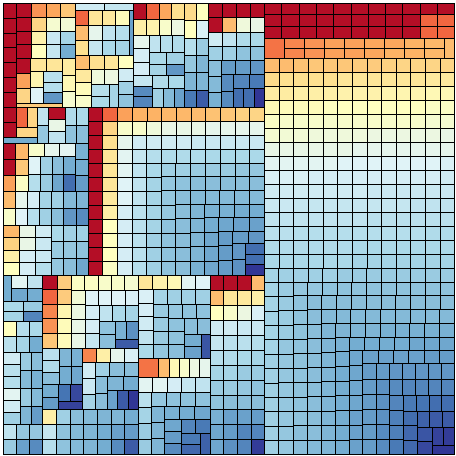

In [172]:
img2

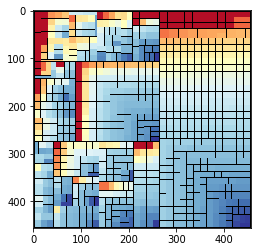

In [149]:
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(img2)

In [99]:
import numpy as np
from PIL import Image # conda install pillow

image = Image.open('prueba.png', mode="rgb")
nparray=np.array(image)

ValueError: bad mode 'rgb'

In [ ]:
img = img.convert("RGBA")

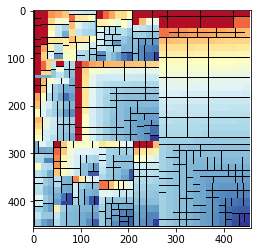

In [12]:
df_gene_exp = pd.read_hdf("data/TCGA_data.h5", key='both_gene_expression') # all

In [13]:
pat1 = pd.DataFrame(df_gene_exp.iloc[0])
pat1['ensId'] = pat1.index
del df_gene_exp

In [13]:
pat1 = pd.merge(gene_mapping, pat1, on='ensId')

In [36]:
pat1['ensId'].shape

(32004,)

In [62]:
pat1.to_csv('pat1.csv')

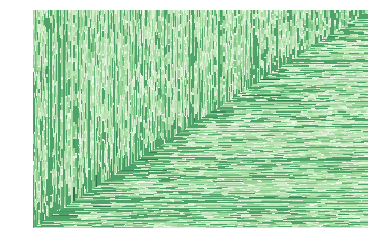

In [98]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
my_values=abs(pat1['TCGA-19-1787-01'])*100
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Greens
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors)
plt.axis('off')
plt.show()

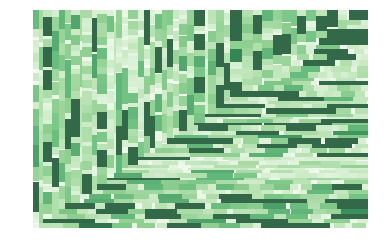

In [106]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
pat1_ = pat1.loc[pat1['Functional Annotation']=="Transcription factors"]
my_values=abs(pat1_['TCGA-19-1787-01'])*100
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Greens
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors)
plt.axis('off')
plt.show()

In [69]:
first_tree = pd.DataFrame(gene_mapping['Functional Annotation'].value_counts())

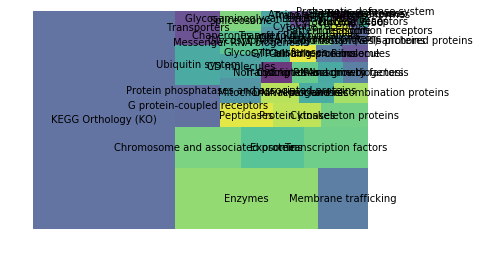

In [100]:
squarify.plot(sizes=first_tree['Functional Annotation'], label=first_tree.index, alpha=.8)
plt.axis('off')
plt.show()

In [92]:
import squarify

# these values define the coordinate system for the returned rectangles
# the values will range from x to x + width and y to y + height
x = 0.
y = 0.
width = 700.
height = 433.

values = [500, 433, 78, 25, 25, 7]

# values must be sorted descending (and positive, obviously)
values.sort(reverse=True)

# the sum of the values must equal the total area to be laid out
# i.e., sum(values) == width * height
values = squarify.normalize_sizes(values, width, height)

# returns a list of rectangles
rects = squarify.squarify(values, x, y, width, height)

# padded rectangles will probably visualize better for certain cases
padded_rects = squarify.padded_squarify(values, x, y, width, height)

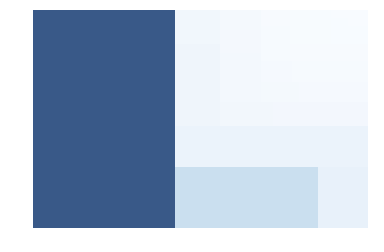

In [18]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
my_values=pd.DataFrame(gene_mapping['Functional Annotation'].value_counts())['Functional Annotation']
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors )
plt.axis('off')
plt.show()
